In [28]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from datetime import datetime,timedelta
import matplotlib.dates as mdates
import sys 
import csv

from utils import *

country_iso_3 = sys.argv[1]

ASSESSMENT_DATE='2020-09-09'
# TODAY = date.today()
TODAY = datetime.strptime(ASSESSMENT_DATE, '%Y-%m-%d').date()
FOUR_WEEKS = TODAY + timedelta(days=28)
TWO_WEEKS = TODAY + timedelta(days=14)
LAST_TWO_MONTHS = TODAY - timedelta(days=60)

MIN_QUANTILE=0.25
MAX_QUANTILE=0.75
# MIN_QUANTILE=0.05
# MAX_QUANTILE=0.95

CONFIG_FILE = 'config.yml'
# DIR_PATH = os.path.dirname(os.path.realpath(__file__))
WHO_COVID_URL='https://covid19.who.int/WHO-COVID-19-global-data.csv'
WHO_COVID_FILENAME='WHO_data/WHO-COVID-19-global-data.csv'
RESULTS_FILENAME=f'automated_reports/report_metrics/{country_iso_3}_results.csv'

NPI_COLOR='green'
NO_NPI_COLOR='red'
WHO_DATA_COLOR='dodgerblue'
SUBNATIONAL_DATA_COLOR='navy'

In [29]:
country_iso3="SDN"# AFG SSD SDN COD SOM IRQ
parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
#     if download_covid:
#         # Download latest covid file tiles and read them in
#         download_who_covid_data(WHO_COVID_URL,f'{DIR_PATH}/{WHO_COVID_FILENAME}')
set_matlotlib(plt)
# print('\n\n\n')
# print(f'{country_iso3}')

In [30]:
from mapclassify import UserDefined
import mapclassify as mc

In [31]:
hist_data=get_who(WHO_COVID_FILENAME,parameters['iso2_code'],min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS)

In [32]:
hist_data

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-03-14,SD,Sudan,EMRO,5,5,0,0
2020-03-15,SD,Sudan,EMRO,0,5,1,1
2020-03-16,SD,Sudan,EMRO,0,5,0,1
2020-03-17,SD,Sudan,EMRO,0,5,0,1
2020-03-18,SD,Sudan,EMRO,0,5,0,1
...,...,...,...,...,...,...,...
2020-09-06,SD,Sudan,EMRO,218,13407,9,832
2020-09-07,SD,Sudan,EMRO,30,13437,1,833
2020-09-08,SD,Sudan,EMRO,0,13437,0,833


In [33]:
import numpy as np
import matplotlib.colors as mcolors

In [80]:
def create_subnational_map(country_iso3, parameters):
    # Total cases - four weeks projection
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
    bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
    bucky_npi = bucky_npi.loc[TWO_WEEKS,:]
    adm1_pcode_prefix=parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix='IQG'
    bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
    bucky_npi["cases_per_100k"]=bucky_npi["cases_per_100k"].astype(int)
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    fig_title=f'{country_iso3}: Projected number of cases per 100,000 people'
    # fig_title=f'Ranking: number of cases per 100,000 people on {TWO_WEEKS}'
    fig,axis=create_new_subplot(fig_title)
    axis.axis('off')
    
    hist_bucky=get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY-timedelta(days=90),max_date=TODAY,npi_filter='npi')
    hist_bucky["cases_per_100k"]=hist_bucky["cases_per_100k"].astype(int)
    hist_buckys=hist_bucky[hist_bucky['q']==0.5]
    cases_max=hist_buckys["cases_per_100k"].max()
#     cases_min=hist_bucky["cases_per_100k"].min()
    scheme="UserDefined"#'quantiles'
    num_colors=5#min(5,len(bucky_npi.cases_per_100k.unique()))
    cmap="YlOrRd"#"viridis"#"YlOrRd"#"viridis"
#     bins_list=[0,10,50,70,200,300,400,600,900,1200,1700,2400,5000] 
#     shapefile["cases_per_100k"]=shapefile["cases_per_100k"].astype(int)
#     max_cases=shapefile["cases_per_100k"].max()
#     max_bin=next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)
#     bins_listc=bins_list[:1+next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)]
#     print(bins_listc)
    print(cases_max)
    bins_list=np.linspace(0,cases_max*1.2,num_colors+1,dtype=int)
#     bins_list=mc.EqualInterval([0,cases_max*1.2], k=5)
#     bins_list=mc.EqualInterval(bucky_npi.cases_per_100k, k=5)
# q10 = mapclassify.Quantiles(gdf.SIDR79,k=10)
    print(bins_list)
    print(bucky_npi.cases_per_100k.unique())
#     shapefile.plot(column='cases_per_100k',ax=axis,cmap='OrRd',legend_kwds={"title":"bla"},legend=True
# #                       legend_kwds={'orientation': "horizontal"}
#                    )
#,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap
#                    ,scheme=scheme, legend=True, legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75)),
#             classification_kwds=dict(bins=bins_list)#,orientation="horizontal")

# )
    
#     shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].dropna(), bins_list)).plot(
#     column='cl', ax=ax1, cmap='OrRd'
# )
    norm2 = mcolors.BoundaryNorm(boundaries=bins_list, ncolors=256) 
    shapefile.plot(column='cases_per_100k', cmap="YlOrRd", norm=norm2,ax=axis)
    fig.colorbar(axis.collections[0], cax = fig.add_axes([0.9, 0.2, 0.03, 0.60]))
    
#     shapefile.assign(cl=UserDefined(shapefile['cases_per_100k'].dropna(), bins_list).yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True)
#     shapefile.assign(cl=bins_list.yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True) #categorical=True,
#     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap, legend=True
#                ,scheme=scheme,
#          legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75), title="Legend\n", frameon=False),
#         classification_kwds=dict(bins=bins_list)#)#,orientation="horizontal")

#     )
#     fig.colorbar(axis.collections[0], ax=axis)
#     shapefile.plot(column='cases_per_100k', figsize=(10, 10),edgecolor='gray',ax=axis,
#                    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(shapefile)
#                    )
#     print(shapefile.cases_per_100k.value_counts())
    vmin = shapefile.cases_per_100k.min()
    vmax = shapefile.cases_per_100k.max()
    
#     cax = fig.add_axes([0.1, 0.1, 0.8,0.03])
# #     cax = fig.add_axes([1, 0.1, 0.03, 0.8])
#     sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     sm._A = []
#     cbr = fig.colorbar(sm, cax=cax, orientation="horizontal")
#     shapefile.boundary.plot(linewidth=0.1,ax=axis)
#     fig.savefig(f'Outputs/{country_iso3}/map_cases_per_100k_2w.png')

#     leg = axis.get_legend()
# #     print(max_bin)
#     for lbl in leg.get_texts():
#         label_text = lbl.get_text()
#     #                 print(label_text)
# #         print(label_text)
#         upper = label_text.split(",")[-1].rstrip(']')

# #         print("f",upper)
#         if int(float(upper)) > bins_listc[-1]:
# #             print("blub")
#             new_text = f'_'
#         else:
#             new_text=label_text
#         lbl.set_text(new_text)
    plt.show()

144
[  0  34  69 103 138 172]
[147   0  13   6  53   3   5  38]


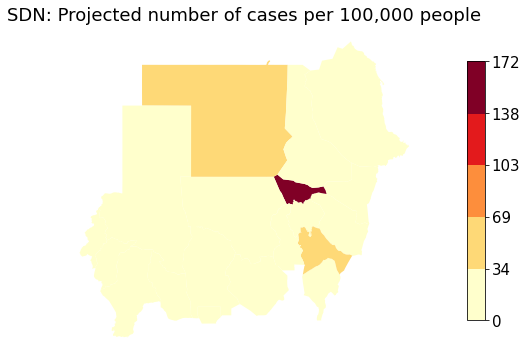

84
[  0  20  40  60  80 100]
[ 9  0  4 13  5  2 11 21 59 65 36  3 41 12 25 10]


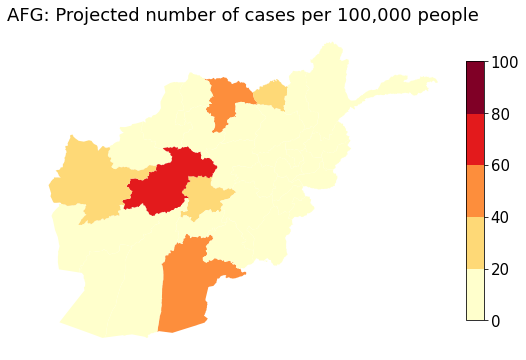

1
[0 0 0 0 0 1]
[0 1]


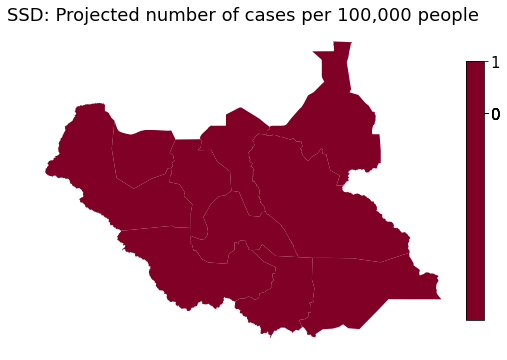

10
[ 0  2  4  7  9 12]
[8 0 2]


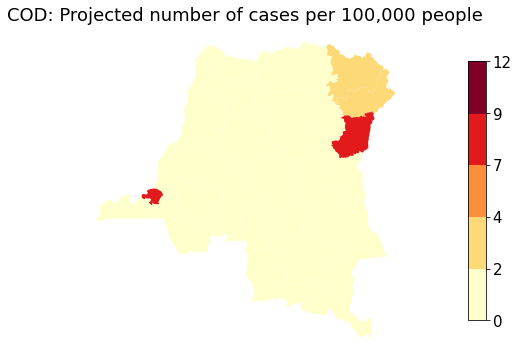

48
[ 0 11 23 34 46 57]
[ 1 39  0  2]


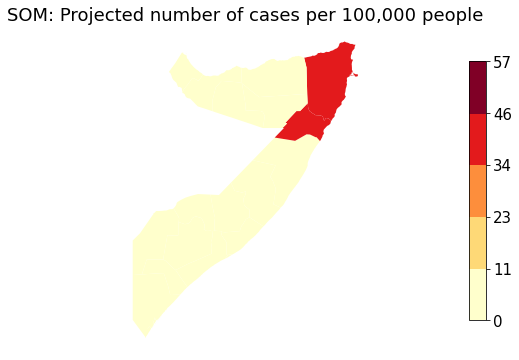

2986
[   0  716 1433 2149 2866 3583]
[ 340  715 1416  707 1056  736  493 2251 1364  699  798  879  809  928
  612  694 1235 1086]


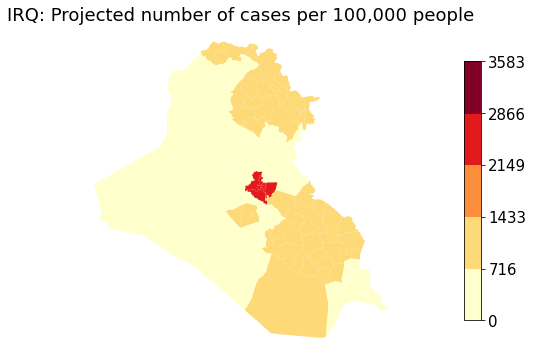

In [81]:
for country_iso3 in ["SDN","AFG", "SSD", "COD", "SOM", "IRQ"]:
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    create_subnational_map(country_iso3,parameters)

In [36]:
def create_subnational_map(country_iso3, parameters):
    # Total cases - four weeks projection
    parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
    bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY,max_date=TWO_WEEKS,npi_filter='npi')
    bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
    bucky_npi = bucky_npi.loc[TWO_WEEKS,:]
    adm1_pcode_prefix=parameters['iso2_code']
    if country_iso3 == 'IRQ':
        adm1_pcode_prefix='IQG'
    bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
    bucky_npi["cases_per_100k"]=bucky_npi["cases_per_100k"].astype(int)
    shapefile = gpd.read_file(parameters['shape'])
    shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')
    fig_title=f'{country_iso3}: Projected number of cases per 100,000 people'
    # fig_title=f'Ranking: number of cases per 100,000 people on {TWO_WEEKS}'
    fig,axis=create_new_subplot(fig_title)
    axis.axis('off')
    
#     hist_bucky=get_bucky(country_iso3 ,admin_level='adm1',min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS,npi_filter='npi')
#     hist_bucky["cases_per_100k"]=hist_bucky["cases_per_100k"].astype(int)
#     cases_max=hist_bucky["cases_per_100k"].max()
#     cases_min=hist_bucky["cases_per_100k"].min()
    scheme="UserDefined"#'quantiles'
    num_colors=5#min(5,len(bucky_npi.cases_per_100k.unique()))
    cmap="YlOrRd"#"viridis"#"YlOrRd"#"viridis"
#     bins_list=[0,10,50,70,200,300,400,600,900,1200,1700,2400,5000] 
#     shapefile["cases_per_100k"]=shapefile["cases_per_100k"].astype(int)
#     max_cases=shapefile["cases_per_100k"].max()
#     max_bin=next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)
#     bins_listc=bins_list[:1+next(x[0] for x in enumerate(bins_list) if x[1] > max_cases)]
#     print(bins_listc)
    bins_list=np.linspace(0,cases_max,num_colors+1,dtype=int)
#     bins_list=mc.EqualInterval([0,cases_max*1.2], k=5)
#     bins_list=mc.EqualInterval(bucky_npi.cases_per_100k, k=5)
# q10 = mapclassify.Quantiles(gdf.SIDR79,k=10)
    print(bins_list)
    print(bucky_npi.cases_per_100k.unique())
#     shapefile.plot(column='cases_per_100k',ax=axis,cmap='OrRd',legend_kwds={"title":"bla"},legend=True
# #                       legend_kwds={'orientation': "horizontal"}
#                    )
#,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap
#                    ,scheme=scheme, legend=True, legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75)),
#             classification_kwds=dict(bins=bins_list)#,orientation="horizontal")

# )
    
#     shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].dropna(), bins_list)).plot(
#     column='cl', ax=ax1, cmap='OrRd'
# )
    norm2 = mcolors.BoundaryNorm(boundaries=bins_list, ncolors=256) 
    shapefile.plot(column='cases_per_100k', cmap="YlOrRd", norm=norm2,ax=axis)
    fig.colorbar(axis.collections[0], cax = fig.add_axes([0.9, 0.2, 0.03, 0.60]))
    
#     shapefile.assign(cl=UserDefined(shapefile['cases_per_100k'].dropna(), bins_list).yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True)
#     shapefile.assign(cl=bins_list.yb).plot(column='cl',  k=10, cmap='OrRd', linewidth=0.1, ax=axis, edgecolor='white', legend=True) #categorical=True,
#     shapefile.plot('cases_per_100k',  ax=axis, cmap=cmap, legend=True
#                ,scheme=scheme,
#          legend_kwds=dict(loc='upper right', bbox_to_anchor=(1.5, 0.75), title="Legend\n", frameon=False),
#         classification_kwds=dict(bins=bins_list)#)#,orientation="horizontal")

#     )
#     fig.colorbar(axis.collections[0], ax=axis)
#     shapefile.plot(column='cases_per_100k', figsize=(10, 10),edgecolor='gray',ax=axis,
#                    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(shapefile)
#                    )
#     print(shapefile.cases_per_100k.value_counts())
    vmin = shapefile.cases_per_100k.min()
    vmax = shapefile.cases_per_100k.max()
    
#     cax = fig.add_axes([0.1, 0.1, 0.8,0.03])
# #     cax = fig.add_axes([1, 0.1, 0.03, 0.8])
#     sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     sm._A = []
#     cbr = fig.colorbar(sm, cax=cax, orientation="horizontal")
#     shapefile.boundary.plot(linewidth=0.1,ax=axis)
#     fig.savefig(f'Outputs/{country_iso3}/map_cases_per_100k_2w.png')

#     leg = axis.get_legend()
# #     print(max_bin)
#     for lbl in leg.get_texts():
#         label_text = lbl.get_text()
#     #                 print(label_text)
# #         print(label_text)
#         upper = label_text.split(",")[-1].rstrip(']')

# #         print("f",upper)
#         if int(float(upper)) > bins_listc[-1]:
# #             print("blub")
#             new_text = f'_'
#         else:
#             new_text=label_text
#         lbl.set_text(new_text)
    plt.show()

In [37]:
# bins = Quantiles(pop_gdf['central_pop'], 5).bins


# pop_gdf.assign(cl=User_Defined(pop_gdf['low_pop'].dropna(), bins).yb).plot(
#     column='cl', ax=ax1, cmap='OrRd'
# )
# pop_gdf.plot('central_pop', scheme='quantiles',  ax=ax2, cmap='OrRd', legend=True, cax=ax3,
#              legend_kwds=dict(loc='upper right', bbox_to_anchor=(3.5, 0.75), title="Legend\n", frameon=False)

# )
# pop_gdf.assign(cl=User_Defined(pop_gdf['high_pop'].dropna(), list(bins)).yb).plot(
#     column='cl', ax=ax3, cmap='OrRd', legend=False
# )

In [87]:
country_iso3="IRQ"
parameters = utils.parse_yaml(CONFIG_FILE)[country_iso3]
bucky_npi =  get_bucky(country_iso3 ,admin_level='adm1',min_date=pd.to_datetime('2000-01-01'),max_date=FOUR_WEEKS,npi_filter='npi')
print(bucky_npi.index.unique())
bucky_npi = bucky_npi[bucky_npi['q']==0.5][['adm1','cases_per_100k']]
bucky_npit=bucky_npi.loc[TODAY]
bucky_npi = bucky_npi.loc[TWO_WEEKS]
print(bucky_npi.index.unique())
adm1_pcode_prefix=parameters['iso2_code']
if country_iso3 == 'IRQ':
    adm1_pcode_prefix='IQG'
bucky_npi['adm1']=adm1_pcode_prefix + bucky_npi['adm1'].apply(lambda x:  "{0:0=2d}".format(int(x)))
shapefile = gpd.read_file(parameters['shape'])
shapefile = shapefile.merge(bucky_npi, left_on=parameters['adm1_pcode'], right_on='adm1', how='left')

Index([2020-09-08, 2020-09-09, 2020-09-10, 2020-09-11, 2020-09-12, 2020-09-13,
       2020-09-14, 2020-09-15, 2020-09-16, 2020-09-17, 2020-09-18, 2020-09-19,
       2020-09-20, 2020-09-21, 2020-09-22, 2020-09-23, 2020-09-24, 2020-09-25,
       2020-09-26, 2020-09-27, 2020-09-28, 2020-09-29, 2020-09-30, 2020-10-01,
       2020-10-02, 2020-10-03, 2020-10-04, 2020-10-05, 2020-10-06, 2020-10-07],
      dtype='object', name='date')
Index([2020-09-23], dtype='object', name='date')


In [90]:
bucky_npit

,adm1,cases_per_100k
date,,
2020-09-09,1.0,222.309227
2020-09-09,2.0,1193.741280
2020-09-09,3.0,2845.523091
2020-09-09,4.0,971.959182
2020-09-09,5.0,1830.692858
2020-09-09,6.0,1506.647664
2020-09-09,7.0,716.863449
2020-09-09,8.0,2421.012391
2020-09-09,9.0,1552.444919


In [88]:
bucky_npi

,adm1,cases_per_100k
date,,
2020-09-23,IQG01,340.184676
2020-09-23,IQG02,715.187251
2020-09-23,IQG03,1416.965672
2020-09-23,IQG04,707.544013
2020-09-23,IQG05,1056.321402
2020-09-23,IQG06,736.488989
2020-09-23,IQG07,493.018361
2020-09-23,IQG08,2251.278366
2020-09-23,IQG09,1364.043225


In [89]:
bucky_npi["prev"]=bucky_npit.loc[bucky_npi.adm1==bucky_npit.adm1,"cases_per_100k"]

ValueError: Can only compare identically-labeled Series objects

In [71]:
b=get_bucky(country_iso3 ,admin_level='adm1',min_date=TODAY-timedelta(days=90),max_date=TWO_WEEKS,npi_filter='npi')

In [82]:
b

,adm1,q,cases_asymptomatic_active,cumulative_deaths,daily_cases,daily_cases_reported,daily_deaths,cumulative_cases,cumulative_cases_reported,ICU,VENT,CASE_REPORT,Reff,doubling_t,N,cases_active,hospitalizations,cases_per_100k
date,,,,,,,,,,,,,,,,,,
2020-09-08,1.0,0.05,598.47440,63.99900,-1373.01100,-56.65795,0.00000,49599.31130,3420.34200,9.32950,6.27140,0.029,1.100987,29.431012,1854583.386,2542.59380,38.89395,137.097842
2020-09-08,1.0,0.25,1096.43700,63.99900,-834.25725,-37.08425,0.00000,62031.61400,3439.91550,13.99475,10.19075,0.038,1.120241,35.406570,1854583.388,3365.04650,54.69000,181.444874
2020-09-08,1.0,0.50,1474.70900,63.99900,-561.01500,-26.02400,0.00000,74290.33000,3450.97600,18.61750,13.79400,0.046,1.135411,39.626553,1854583.389,4231.78850,71.41800,228.180007
2020-09-08,1.0,0.75,2011.24925,63.99900,-345.28725,-16.40825,0.00000,89704.82150,3460.59200,24.82600,18.52925,0.056,1.157123,43.700304,1854583.390,5320.22150,92.31575,286.868821
2020-09-08,1.0,0.95,2975.07285,63.99900,-143.04165,-7.31245,0.00000,119394.17585,3469.68660,36.46010,28.16595,0.070,1.218390,49.868717,1854583.392,7392.24500,131.04690,398.593292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,18.0,0.05,3445.81885,352.44605,1158.45895,66.50155,2.49785,178458.68735,16324.52905,37.37770,25.45160,0.042,1.101198,30.114601,1384280.874,8041.37290,160.55675,580.906162
2020-09-23,18.0,0.25,5684.10850,370.52450,1523.13500,93.79575,3.28400,219798.04700,16896.66825,56.79275,39.80025,0.056,1.119293,35.878923,1384280.876,11780.64000,234.85325,851.029600
2020-09-23,18.0,0.50,7615.58450,384.83800,1806.49300,120.87600,3.93050,259641.53100,17378.66200,74.40850,53.97800,0.067,1.134589,39.768911,1384280.877,15046.86700,299.63700,1086.980775


In [72]:
b.q.value_counts()

0.05    288
0.95    288
0.75    288
0.50    288
0.25    288
Name: q, dtype: int64

In [73]:
b.index.value_counts()

2020-09-09    90
2020-09-10    90
2020-09-11    90
2020-09-13    90
2020-09-23    90
2020-09-15    90
2020-09-19    90
2020-09-18    90
2020-09-22    90
2020-09-16    90
2020-09-14    90
2020-09-21    90
2020-09-20    90
2020-09-12    90
2020-09-08    90
2020-09-17    90
Name: date, dtype: int64

In [74]:
b[b.q==0.5]

,adm1,q,cases_asymptomatic_active,cumulative_deaths,daily_cases,daily_cases_reported,daily_deaths,cumulative_cases,cumulative_cases_reported,ICU,VENT,CASE_REPORT,Reff,doubling_t,N,cases_active,hospitalizations,cases_per_100k
date,,,,,,,,,,,,,,,,,,
2020-09-08,1.0,0.5,1474.7090,63.9990,-561.0150,-26.0240,0.0000,74290.3300,3450.9760,18.6175,13.7940,0.046,1.135411,39.626553,1854583.389,4231.7885,71.4180,228.180007
2020-09-09,1.0,0.5,1518.3740,65.2540,485.2250,22.6575,1.2510,74724.7505,3473.4920,18.5055,13.5960,0.046,1.135411,39.626553,1854583.390,4122.9100,69.9460,222.309227
2020-09-10,1.0,0.5,1606.7170,66.4175,577.1365,26.6320,1.1650,75242.9405,3501.4430,18.6685,13.8485,0.046,1.135411,39.626553,1854583.390,4060.1210,70.4255,218.923615
2020-09-11,1.0,0.5,1739.4650,67.5440,661.1610,29.9075,1.0810,75872.9630,3532.7370,19.3085,14.4990,0.046,1.135411,39.626553,1854583.390,4107.3485,73.4840,221.470144
2020-09-12,1.0,0.5,1878.6175,68.5820,712.1675,32.4445,1.0485,76617.1040,3565.1955,20.2825,15.1950,0.046,1.135411,39.626553,1854583.390,4225.8015,77.0910,227.857185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,18.0,0.5,8542.2205,366.4985,1980.1120,133.7450,5.2550,251919.2425,16863.6895,89.1590,65.2235,0.067,1.134419,39.768911,1384280.877,17422.3255,348.6645,1258.583124
2020-09-20,18.0,0.5,8288.0470,371.5145,1934.9890,130.1405,4.8680,253872.1575,16995.4375,85.4440,61.5755,0.067,1.134419,39.768911,1384280.877,16819.3750,334.8365,1215.026176
2020-09-21,18.0,0.5,8062.6255,375.9365,1895.6250,127.1360,4.5440,255761.2780,17122.3575,81.9985,58.8035,0.067,1.134419,39.768911,1384280.877,16180.0155,321.3350,1168.839053


In [177]:
# shapefile.ADM0_EN.unique()

In [178]:
print(f"Number of occurences for {country_iso3}")
cases_count=pd.DataFrame(shapefile.cases_per_100k.astype(int).value_counts().sort_index())
cases_count.index=cases_count.index.rename("Cases per 100k")
cases_count.columns=["Occurences"]
cases_count

Number of occurences for IRQ


,Occurences
Cases per 100k,
340,7
493,4
612,9
694,7
699,6
707,3
715,7
736,10
798,6


In [157]:
sorted(shapefile.cases_per_100k.astype(int).unique())

[0, 2, 3, 4, 5, 9, 10, 11, 12, 13, 21, 25, 36, 41, 59, 65]

In [138]:
bins_list=[0,70,200,300,400,600,900,1200,1700,2400,5000] 

In [139]:
m=shapefile.cases_per_100k.max()

In [140]:
ni=next(x[0] for x in enumerate(bins_list) if x[1] > m)

In [141]:
bins_list[:ni+1]

[0, 70]

In [142]:
UserDefined(shapefile["cases_per_100k"].astype(int).dropna(), bins_list)

UserDefined               

     Interval        Count
--------------------------
[   0.00,    0.00] |    13
(   0.00,   70.00] |    21
(  70.00,  200.00] |     0
( 200.00,  300.00] |     0
( 300.00,  400.00] |     0
( 400.00,  600.00] |     0
( 600.00,  900.00] |     0
( 900.00, 1200.00] |     0
(1200.00, 1700.00] |     0
(1700.00, 2400.00] |     0
(2400.00, 5000.00] |     0

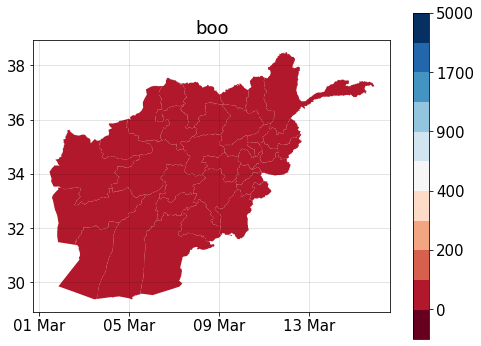

In [148]:
fig,axis=create_new_subplot("boo")
bounds = np.array([-5,0,70,200,300,400,600,900,1200,1700,2400,5000])  #np.array([-0.02, -0.01, 0., 0.01, 0.02, 0.03])
norm2 = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256) 
shapefile.plot(column='cases_per_100k', cmap='RdBu', norm=norm2,ax=axis)
fig.colorbar(axis.collections[0], ax=axis)

In [124]:
shapefile.assign(cl=UserDefined(shapefile["cases_per_100k"].astype(int).dropna(), bins_list))

TypeError: '<' not supported between instances of 'float' and 'str'

In [35]:
shapefile.dtypes

Shape_Leng         float64
Shape_Area         float64
ADM1_EN             object
ADM1_AR             object
ADM1_PCODE          object
ADM1_REF            object
ADM1ALT1EN          object
ADM1ALT2EN          object
ADM1ALT1AR          object
ADM1ALT2AR          object
ADM0_EN             object
ADM0_AR             object
ADM0_PCODE          object
date                object
validOn             object
validTo             object
geometry          geometry
adm1                object
cases_per_100k     float64
dtype: object